In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
#softsign
import os

# Configure TensorFlow to use GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# Load CSV file
df = pd.read_csv(r"C:\Users\abdel\Downloads\data set\SQLiV3.csv")

print(df.columns)
for i in range(0, 20921):
    if pd.isnull(df.iloc[i, 0]):
        df.iloc[i, 0] = df.iloc[i, 1]
    elif pd.isnull(df.iloc[i, 1]):
        df.iloc[i, 1] = df.iloc[i, 2]
print(df.isna().sum())
print(df.head())

# Data Cleaning
df['Label'] = df['Label'].astype(str)
df = df[~df['Label'].str.contains('[a-zA-Z]')]
df['Label'] = pd.to_numeric(df['Label'], errors='coerce', downcast='integer')
df['Label'] = df['Label'].astype('float32')
df = df.dropna(subset=['Sentence', 'Label'])

# Split data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization and Padding
max_words = 10000
max_sequence_length = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['Sentence'])
train_sequences = tokenizer.texts_to_sequences(train_data['Sentence'])
test_sequences = tokenizer.texts_to_sequences(test_data['Sentence'])
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

#  RNN Model
embedding_dim = 50  # Increased embedding dimension
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(256, return_sequences=True)),  # Increased LSTM units
    Dropout(0.5),
    Bidirectional(LSTM(256)),
    Dense(128, activation='softsign'),  # Additional dense layer
    Dropout(0.5),
    Dense(1, activation='softsign')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training
labels_train = train_data['Label']
labels_test = test_data['Label']
model.fit(train_padded, labels_train, epochs=10, validation_data=(test_padded, labels_test), callbacks=[early_stopping])

# Evaluate
test_loss, test_accuracy = model.evaluate(test_padded, labels_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Index(['Sentence', 'Label', 'Unnamed: 2', 'Unnamed: 3'], dtype='object')
Sentence          1
Label             0
Unnamed: 2    30916
Unnamed: 3    31209
dtype: int64
                                            Sentence Label Unnamed: 2  \
0                  " or pg_sleep  (  __TIME__  )  --     1        NaN   
1  create user name identified by pass123 tempora...     1          1   
2   AND 1  =  utl_inaddr.get_host_address   (    ...     1        NaN   
3   select * from users where id  =  '1' or @ @1 ...     1        NaN   
4   select * from users where id  =  1 or 1#"  ( ...     1        NaN   

   Unnamed: 3  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
Epoch 1/10
780/780 [==============================] - 70s 75ms/step - loss: 0.5090 - accuracy: 0.8015 - val_loss: 0.1241 - val_accuracy: 0.9920
Epoch 2/10
780/780 [==============================] - 59s 75ms/step - loss: 0.1251 - accuracy: 0.9899 - val_loss: 0.0904 - val_accuracy: 0.9941
Epoch 3/10


195/195 [==============================] - 6s 27ms/step


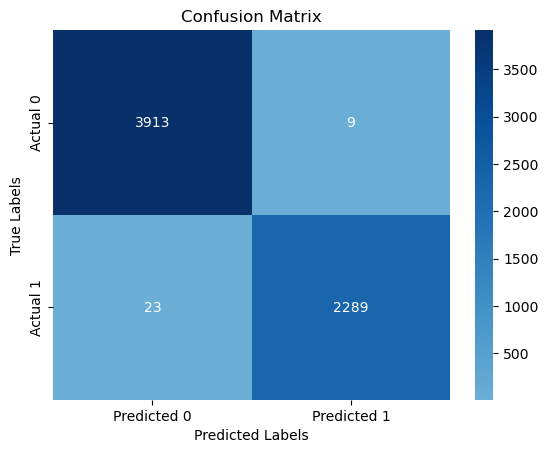

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3922
         1.0       1.00      0.99      0.99      2312

    accuracy                           0.99      6234
   macro avg       1.00      0.99      0.99      6234
weighted avg       0.99      0.99      0.99      6234



In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Predictions
y_pred_prob = model.predict(test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(labels_test, y_pred)

# Calculate TP, FP, TN, FN
tp = cm[1, 1]
fp = cm[0, 1]
tn = cm[0, 0]
fn = cm[1, 0]

# Create a DataFrame for better visualization
confusion_df = pd.DataFrame(
    data=[[tn, fp], [fn, tp]],
    index=['Actual 0', 'Actual 1'],
    columns=['Predicted 0', 'Predicted 1']
)

# Plot the heatmap
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', center=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(labels_test, y_pred))